# Generate QC report with a platemap of the FOVs per well

## Import libraries

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(stringr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(platetools))

Warning message:
“package ‘stringr’ was built under R version 4.2.3”
Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”
Warning message:
“package ‘platetools’ was built under R version 4.2.3”


## Set functions

In [2]:
# Function to extract well and FOV information and return summarized results for each folder
extract_well_fov_from_folder <- function(folder_path) {
  # List all TIFF files in the folder
  files <- list.files(path = folder_path, full.names = TRUE, pattern = "\\.tiff$")
  
  # Check if any TIFF files are found
  if (length(files) == 0) {
    stop(paste("Error: No TIFF files found in folder:", folder_path))
  }
  
  # Create a data frame with well and FOV information
  well_fov_df <- do.call(rbind, lapply(files, function(file) {
    # Regex to extract well (e.g., B02, C10, etc.)
    well <- str_extract(file, "[B-G][0-9]{1,2}")  # Match single or double digits after the letter
    
    # Add leading zero if well is a single digit (e.g., convert B2 to B02)
    well <- ifelse(nchar(well) == 2, 
                   paste0(substr(well, 1, 1), "0", substr(well, 2, 2)), 
                   well)
    # Extract FOV (e.g., f00, f01, etc.)
    fov <- str_extract(file, "f\\d{2}")
    
    # Check if well and FOV are properly extracted
    data.frame(well = well, fov = fov, stringsAsFactors = FALSE)
  }))
  
  # Check if the data frame is not empty
  if (is.null(well_fov_df) || nrow(well_fov_df) == 0) {
    stop(paste("Error: No valid data in folder:", folder_path))
  }
  
  # Count unique FOVs for each well
  result <- well_fov_df %>%
    group_by(well) %>%
    summarise(num_fovs = n_distinct(fov)) %>%
    arrange(well)
  
  return(result)
}

# Function to create the platemap for each folder
create_platemap <- function(counts_per_well, folder_name, output_dir) {
  fov_platemap <- platetools::raw_map(
    data = counts_per_well$num_fovs,            # FOV counts
    well = counts_per_well$well,                # Well IDs
    plate = 96,                                 # 96-well plate format
    size = 8                                    # Size of the well points
  ) +
    ggtitle(paste("Platemap of passed QC FOV count per well in", folder_name)) +
    theme(plot.title = element_text(size = 10, face = "bold")) +
    scale_fill_gradient(
      name = "Passed QC\nFOV count",                       # Gradient color scale for FOV count
      low = "#ffffff",                          # White for low count
      high = "#00008B"                          # Dark blue for high count (hex code for dark blue)
    )
  
  # Save the plot in the specified output directory
  plot_filename <- file.path(output_dir, paste0("fov_platemap_", folder_name, ".png"))
  ggsave(plot_filename, fov_platemap, dpi = 500, height = 3.5, width = 6)
  
  # Display the plot in the notebook
  print(fov_platemap)
}

## Set paths and variables

In [3]:
# List all subdirectories within a parent folder
parent_dir <- "./Corrected_Images"
folders <- list.dirs(path = parent_dir, recursive = FALSE)

# Output for platemap figure
platemap_output_dir <- "qc_figures"

# Check if the directory exists, and create it if it doesn't
if (!dir.exists(platemap_output_dir)) {
  dir.create(platemap_output_dir)
}

## Compute the number of FOVs per well and generate platemap figure per plate

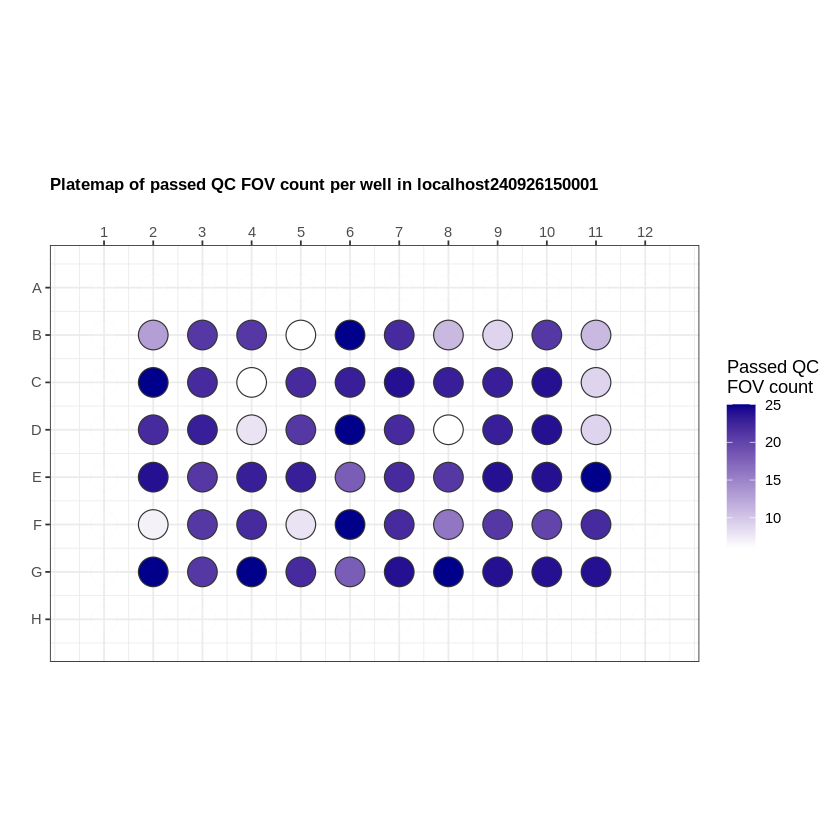

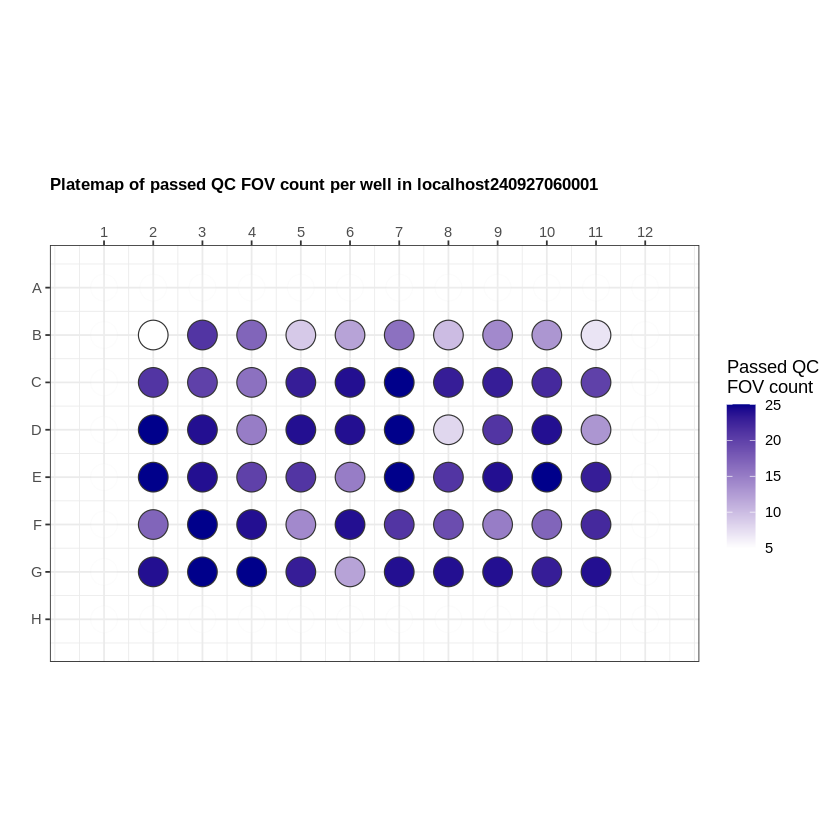

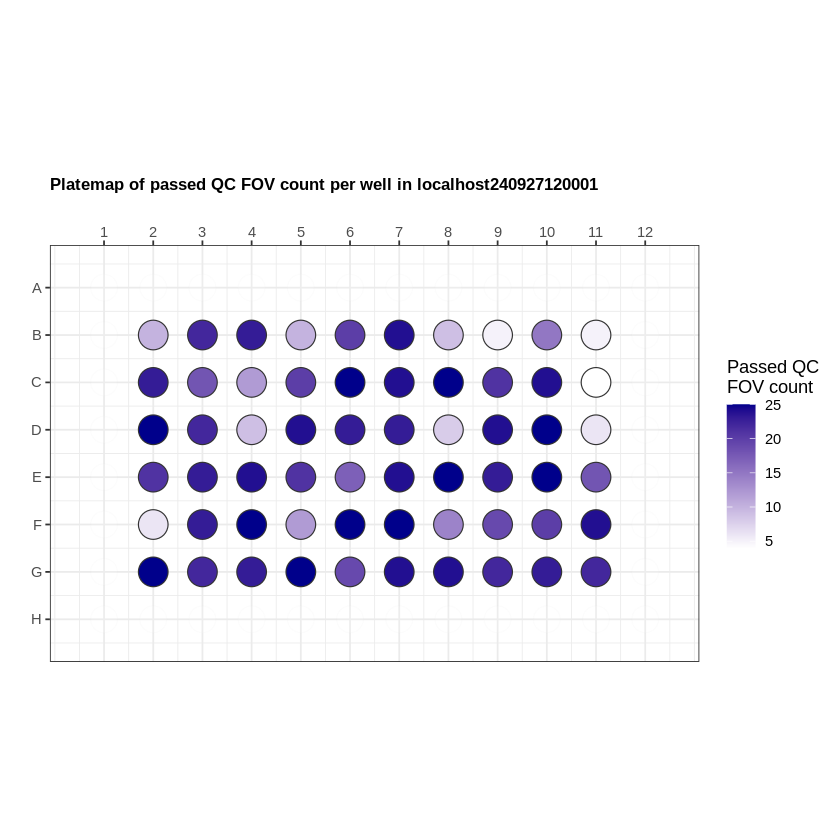

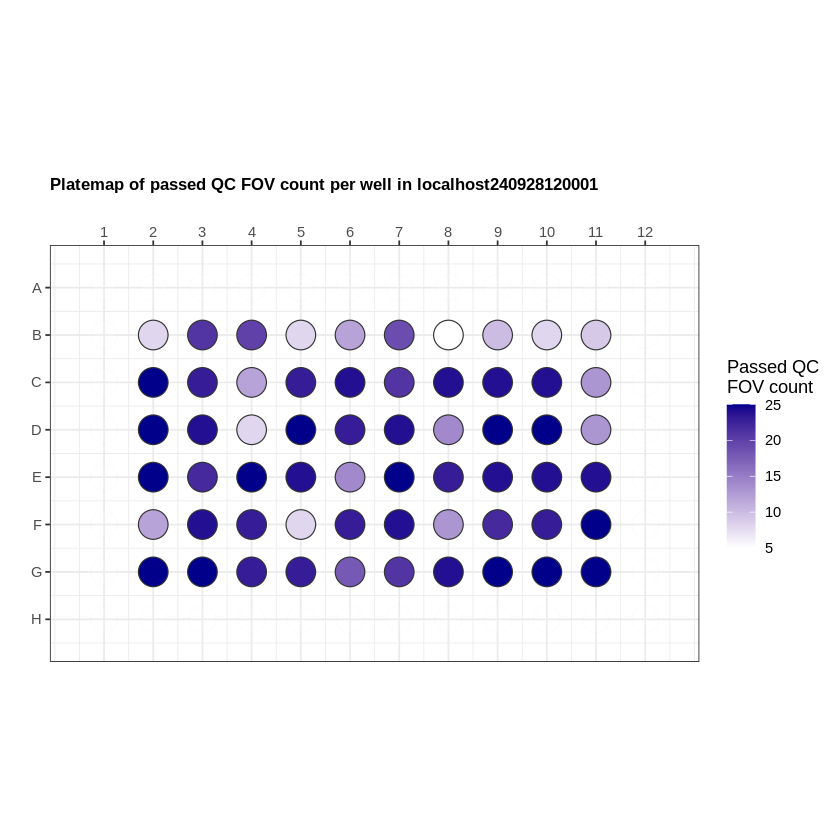

In [4]:
# Loop through each folder and process the data
for (folder in folders) {
  # Get the folder name for labeling purposes
  folder_name <- basename(folder)
  
  # Process the folder and get the summarized FOV data
  counts_per_well <- extract_well_fov_from_folder(folder)
  
  # Create and save the platemap
  create_platemap(counts_per_well, folder_name, platemap_output_dir)
}